# **FEATURE ENGINEERING**

In [ ]:
!pip install pandas_profiling

In [ ]:
import pandas as pd
# read data,Integration with NumPy, provides tools to handle missing data effectively
from pandas_profiling import ProfileReport
# generates a detailed exploratory data analysis (EDA) report for a pandas DataFrame
import numpy as np
# numerical computing
import matplotlib.pyplot as plt
# used for creating static, interactive, and animated visualizations
import plotly.express as px
# simplifies the process of creating visualizations by providing a straightforward and expressive API.
import seaborn as sns
# provides a high-level interface for creating attractive and informative statistical graphics
plt.rcParams['figure.figsize'] = (12,8)
# sets the default figure size for plots  to 12 inches in width and 8 inches in height.
import warnings
warnings.filterwarnings("ignore")

<ipython-input-2-a38a5533d1b1>:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [ ]:
#import files

Beneficiary = pd.read_csv('/content/Train_Beneficiary.csv')
Inpatient = pd.read_csv('/content/Train_Inpatient.csv')
Outpatient = pd.read_csv('/content/Train_Outpatient.csv')
Label = pd.read_csv('/content/Train_Label.csv')

In [ ]:
# adding a new column to two different DataFrames
Inpatient['Patient_type'] = 'inpatient'
Outpatient['Patient_type'] = 'outpatient'

In [ ]:
# concatenate the Inpatient and Outpatient
Patient = pd.concat([Inpatient, Outpatient], axis=0)

In [ ]:
# merges the DataFrames based on specified columns
fraud = pd.merge(Patient, Beneficiary, on='BeneID', how='left')
fraud = pd.merge(fraud, Label, on='Provider', how='left')

In [ ]:
# Creating DaysAdmitted Feature by substracting claim start date from claim end date
# and adds the result as a new column to the fraud DataFrame.
fraud['ClaimStartDt'] = pd.to_datetime(fraud['ClaimStartDt'])
fraud['ClaimEndDt'] = pd.to_datetime(fraud['ClaimEndDt'])
fraud['DaysAdmitted'] = fraud['ClaimEndDt'] - fraud['ClaimStartDt']

In [ ]:
fraud['DaysAdmitted'] = fraud['DaysAdmitted'].astype(str)
fraud['DaysAdmitted'] = fraud['DaysAdmitted'].str.replace('days', ' ')
fraud['DaysAdmitted'] = fraud['DaysAdmitted'].astype(int)
fraud['DaysAdmitted'] = fraud['DaysAdmitted'] + 1

In [ ]:
DaysAdmitted_mean = pd.DataFrame(fraud.groupby('Provider')['DaysAdmitted'].mean()).reset_index()

In [ ]:
Label_Fraud_1 = Label.copy()
Label_Fraud_2 = pd.merge(Label_Fraud_1, DaysAdmitted_mean, on='Provider')

DeductibleAmountPaid Mean

In [ ]:
DeductibleAmtPaid_mean = pd.DataFrame(fraud.groupby('Provider') \
                              ['DeductibleAmtPaid'].mean())
Label_Fraud_2 = pd.merge(Label_Fraud_2, DeductibleAmtPaid_mean, on='Provider')

Insurance Claim Amount Reimbursed Mean

In [ ]:
InscClaimAmtReimbursed_mean = pd.DataFrame(fraud.groupby('Provider') \
                              ['InscClaimAmtReimbursed'].mean())
Label_Fraud_2 = pd.merge(Label_Fraud_2, InscClaimAmtReimbursed_mean, on='Provider')

Add number of patient and Doctors

In [ ]:
doctors= fraud.groupby(['Provider', 'AttendingPhysician']) \
['AttendingPhysician'].count().reset_index(name='NumOfDoctors'). \
groupby('Provider')['NumOfDoctors'].count().reset_index()

Label_Fraud_2 = pd.merge(Label_Fraud_2, doctors, on='Provider')

In [ ]:
patient= fraud.groupby(['Provider','BeneID'])['BeneID'].count(). \
reset_index(name='NumOfPatients').groupby('Provider')['NumOfPatients']. \
count().reset_index()

Label_Fraud_2 = pd.merge(Label_Fraud_2, patient, on='Provider')

Number of Claims

In [ ]:
# calculate the number of unique claims for each provider in the fraud DataFrame

claims= fraud.groupby(['Provider', 'ClaimID'])['ClaimID'].count().\
reset_index(name='NumOfClms').groupby('Provider')['NumOfClms'].count().reset_index()

Label_Fraud_2 = pd.merge(Label_Fraud_2, claims, on='Provider')




Number of county per provider

In [ ]:
#  calculate the number of unique counties associated with each provider
numCounties = fraud.groupby(['Provider', 'County'])['County'].count().reset_index(name='a'). \
groupby('Provider')['County'].count().reset_index(name='numCounties')
Label_Fraud_2 = pd.merge(Label_Fraud_2, numCounties, on='Provider')

Add average number of chronic conditions per provider

In [ ]:
patientChronic_mean = fraud.filter(regex='Chronic').replace(to_replace=2, value=0).sum(axis=1).\
reset_index(name='NumChronicCond')
chronic = pd.concat([patientChronic_mean, fraud[['Provider', 'ClaimID']]], axis=1)

In [ ]:
patientChronic_mean = chronic.groupby(['Provider', 'NumChronicCond'])['ClaimID'].count().reset_index(name='NumClaims').\
groupby('Provider').agg({'NumChronicCond':'mean', 'NumClaims':'mean'}).reset_index().\
rename(columns={'NumChronicCond':'AvgChronic', 'NumClaims':'AvgClaim'})

Label_Fraud_2 = pd.merge(Label_Fraud_2, patientChronic_mean, on='Provider')

Average Age

In [ ]:
# converting date columns 'ClaimStartDt' and 'DOB' in the fraud DataFrame to datetime
# format using a specified format string, and then calculating the age of patients based
# on these dates.

fraud['ClaimStartDt2'] =  pd.to_datetime(fraud['ClaimStartDt'], format='%Y/%m/%d')
fraud['DOB'] =  pd.to_datetime(fraud['DOB'], format='%Y/%m/%d')
fraud['Age'] = fraud['ClaimStartDt'] - fraud['DOB']

In [ ]:
fraud['Age'] = (fraud['Age']/pd.Timedelta(365, unit='d')).astype('int64')

In [ ]:
age_mean = fraud.groupby(['Provider', 'BeneID'])['Age']. \
mean().reset_index(name = "Age").dropna() \
.groupby('Provider')['Age'].mean().reset_index()

In [ ]:
Label_Fraud_2 = pd.merge(Label_Fraud_2, age_mean, on='Provider', how='left')

Gender of patients per provider

In [ ]:
gender = fraud.groupby(['Provider', 'BeneID', 'Gender'])['Gender'].count().reset_index(name = 'GenderCount')
gender['GenderCount'] = gender['GenderCount'].apply(lambda x: 1 if x >= 1 else 0)
gender = gender.groupby('Provider')['Gender'].value_counts().reset_index(name = 'GenderCount')

In [ ]:
# updating the gender DataFrame by creating separate columns 'male' and 'female'

gender['male'] = 0
gender['female'] = 0

for index in gender.index:
    if gender['Gender'][index] == 1:
        gender['male'][index] += gender['GenderCount'][index]
    if gender['Gender'][index] == 2:
        gender['female'][index] += gender['GenderCount'][index]

In [ ]:
#  dropping the 'Gender' and 'GenderCount' columns from the gender DataFrame.

gender = gender.drop('Gender', axis = 1)
gender = gender.drop('GenderCount', axis = 1)

In [ ]:
# grouping the gender DataFrame by the 'Provider' column and aggregating the sum of
# male and female patient counts for each provider.
genderCount = gender.groupby('Provider').agg({'male' : 'sum', 'female' : 'sum'}).reset_index()

In [ ]:
# performs a left merge between the Label_Fraud_2 DataFrame and the genderCount DataFrame
# based on the 'Provider' column. This merge operation adds the total count of male and
# female patients for each provider to the existing Label_Fraud_2

Label_Fraud_2 = pd.merge(Label_Fraud_2, genderCount, on = 'Provider', how = 'left')

In [ ]:
Label_Fraud_2.head()

Provider PotentialFraud  DaysAdmitted  DeductibleAmtPaid  \
0  PRV51001             No      2.440000         213.600000   
1  PRV51003            Yes      4.674242         502.166667   
2  PRV51004             No      2.429530           2.080537   
3  PRV51005            Yes      2.088412           3.175966   
4  PRV51007             No      1.958333          45.333333   

   InscClaimAmtReimbursed  NumOfDoctors  NumOfPatients  NumOfClms  \
0             4185.600000            14             24         25   
1             4588.409091            44            117        132   
2              350.134228            38            138        149   
3              241.124464             6            495       1165   
4              468.194444            10             58         72   

   numCounties  AvgChronic    AvgClaim        Age  male  female  
0            7    5.888889    2.777778  77.729167     9      15  
1           23    5.000000   12.000000  68.507123    49      68  
2           28    4.500000   14.900000  71.977657    45      93  
3           26    4.500000  116.500000  69.552102   208     287  
4            6    4.000000    8.000000  67.568966    27      31

In [ ]:
Label_Fraud_2.to_pickle('dataset.pkl')

In [ ]:
Label_Fraud_2.to_csv('dataset.csv')

In [ ]:
Label_Fraud_2.head()

Provider PotentialFraud  DaysAdmitted  DeductibleAmtPaid  \
0  PRV51001             No      2.440000         213.600000   
1  PRV51003            Yes      4.674242         502.166667   
2  PRV51004             No      2.429530           2.080537   
3  PRV51005            Yes      2.088412           3.175966   
4  PRV51007             No      1.958333          45.333333   

   InscClaimAmtReimbursed  NumOfDoctors  NumOfPatients  NumOfClms  \
0             4185.600000            14             24         25   
1             4588.409091            44            117        132   
2              350.134228            38            138        149   
3              241.124464             6            495       1165   
4              468.194444            10             58         72   

   numCounties  AvgChronic    AvgClaim        Age  male  female  
0            7    5.888889    2.777778  77.729167     9      15  
1           23    5.000000   12.000000  68.507123    49      68  
2           28    4.500000   14.900000  71.977657    45      93  
3           26    4.500000  116.500000  69.552102   208     287  
4            6    4.000000    8.000000  67.568966    27      31

# **MODELLING**


In [ ]:
# library designed for gradient boosting algorithms,
# known for its high performance, efficiency, and flexibility.
# Provides Regularization, Cross-validation, Handling Missing Values, Parallel Processing, Feature Importance,Tree Pruning

import xgboost as xgb

In [ ]:
fraud = pd.read_csv("dataset.csv")

In [ ]:
fraud = fraud.drop("Unnamed: 0",axis=1)
fraud.head()

Provider PotentialFraud  DaysAdmitted  DeductibleAmtPaid  \
0  PRV51001             No      2.440000         213.600000   
1  PRV51003            Yes      4.674242         502.166667   
2  PRV51004             No      2.429530           2.080537   
3  PRV51005            Yes      2.088412           3.175966   
4  PRV51007             No      1.958333          45.333333   

   InscClaimAmtReimbursed  NumOfDoctors  NumOfPatients  NumOfClms  \
0             4185.600000            14             24         25   
1             4588.409091            44            117        132   
2              350.134228            38            138        149   
3              241.124464             6            495       1165   
4              468.194444            10             58         72   

   numCounties  AvgChronic    AvgClaim        Age  male  female  
0            7    5.888889    2.777778  77.729167     9      15  
1           23    5.000000   12.000000  68.507123    49      68  
2           28    4.500000   14.900000  71.977657    45      93  
3           26    4.500000  116.500000  69.552102   208     287  
4            6    4.000000    8.000000  67.568966    27      31

In [ ]:
fraud.columns

Index(['Provider', 'PotentialFraud', 'DaysAdmitted', 'DeductibleAmtPaid',
       'InscClaimAmtReimbursed', 'NumOfDoctors', 'NumOfPatients', 'NumOfClms',
       'numCounties', 'AvgChronic', 'AvgClaim', 'Age', 'male', 'female'],
      dtype='object')

In [ ]:
cols = ['DaysAdmitted', 'DeductibleAmtPaid','InscClaimAmtReimbursed', 'NumOfDoctors', 'NumOfPatients', 'NumOfClms','numCounties', 'AvgChronic', 'AvgClaim', 'Age', 'male', 'female']

In [ ]:
fraud = fraud.dropna() # drops any rows containing missing values

In [ ]:
X = fraud[cols]
Y = fraud["PotentialFraud"].apply(lambda x: True if x == "Yes" else False)

In [56]:
#Splitting Data
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,Y,test_size=0.3,random_state=101,stratify=Y,shuffle=True)

In [57]:
#Training
from sklearn.linear_model import LogisticRegressionCV

log = LogisticRegressionCV(cv=10,class_weight='balanced',random_state=123)
log.fit(X_train,y_train)

LogisticRegressionCV(class_weight='balanced', cv=10, random_state=123)

In [58]:
## Predicting probability of 1 and 0 for X_train and X_val

log_train_pred_probability=log.predict_proba(X_train)
log_val_pred_probability=log.predict_proba(X_val)

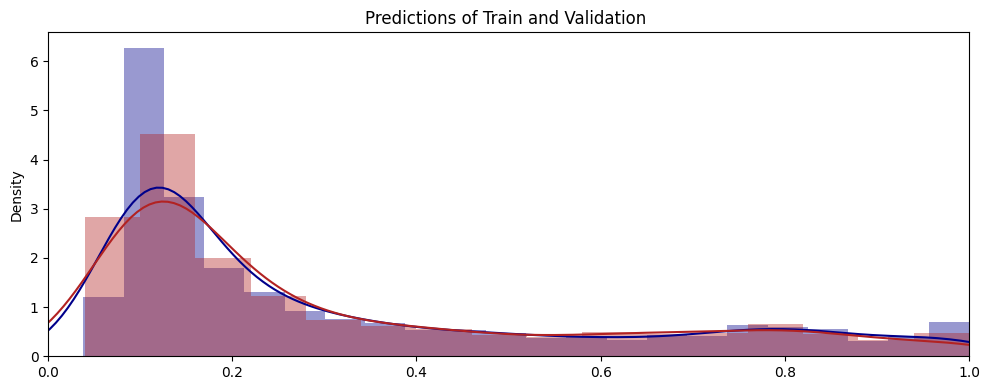

In [59]:
# Comparing model prediction performance on train and Validation both.

fig = plt.figure(figsize=(10,4))

sns.distplot(log.predict_proba(X_train)[:,1],color='darkblue')
sns.distplot(log.predict_proba(X_val)[:,1],color='firebrick')
plt.title('Predictions of Train and Validation ')
plt.xlim([0, 1])

plt.tight_layout()

plt.show()

* The above plot provides insights into how well the model is predicting probabilities for the positive class on both the training and validation sets.

* The plot shows the distribution of predicted probabilities for the positive class from the trained Logistic Regression model

*  The blue curve represents the distribution of predicted probabilities for the positive class in the training set (X_train), and the red curve represents the distribution in the validation set (X_val). The overlapping areas of the curves indicate similarities in the predicted probabilities between the two datasets.



In [61]:
## Set probability Threshold to 0.50

log_train_pred_60=(log.predict_proba(X_train)[:,1]>0.50).astype(bool)
log_val_pred_60=(log.predict_proba(X_val)[:,1]>0.50).astype(bool)   # set threshold as 0.60


In [62]:
#Confusion matrix, Accuracy, sensitivity and specificity

from sklearn.metrics import confusion_matrix,accuracy_score,cohen_kappa_score,roc_auc_score,f1_score,auc

cm0 = confusion_matrix(y_train, log_train_pred_60,labels=[1,0])
print('Confusion Matrix Train : \n', cm0)

cm1 = confusion_matrix(y_val, log_val_pred_60,labels=[1,0])
print('Confusion Matrix Val: \n', cm1)

total0=sum(sum(cm0))
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy0=(cm0[0,0]+cm0[1,1])/total0
print ('Accuracy Train: ', accuracy0)

accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy Val: ', accuracy1)

sensitivity0 = cm0[0,0]/(cm0[0,0]+cm0[0,1])
print('Sensitivity Train : ', sensitivity0 )

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity Val: ', sensitivity1 )


specificity0 = cm0[1,1]/(cm0[1,0]+cm0[1,1])
print('Specificity Train: ', specificity0)

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity Val: ', specificity1)

KappaValue=cohen_kappa_score(y_val, log_val_pred_60)
print("Kappa Value :",KappaValue)
AUC=roc_auc_score(y_val, log_val_pred_60)

print("AUC         :",AUC)

print("F1-Score Train  : ",f1_score(y_train, log_train_pred_60))

print("F1-Score Val  : ",f1_score(y_val, log_val_pred_60))


Confusion Matrix Train : 
 [[ 282   72]
 [ 606 2826]]
Confusion Matrix Val: 
 [[ 115   37]
 [ 261 1210]]
Accuracy Train:  0.820919175911252
Accuracy Val:  0.8163894023413432
Sensitivity Train :  0.7966101694915254
Sensitivity Val:  0.756578947368421
Specificity Train:  0.8234265734265734
Specificity Val:  0.822569680489463
Kappa Value : 0.3487369384897123
AUC         : 0.789574313928942
F1-Score Train  :  0.4541062801932366
F1-Score Val  :  0.4356060606060606


**Random Forest Classification**

In [ ]:
## Applying Random Forest
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=500,class_weight='balanced',random_state=123,max_depth=4)

In [ ]:
rfc.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=500,
                       random_state=123)

In [ ]:
from sklearn.metrics import roc_curve, auc,precision_recall_curve
fpr, tpr, thresholds =roc_curve(y_val, rfc.predict_proba(X_val)[:,1],pos_label=1)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.928830


In [ ]:
# Threshold Setting and Prediction

# Set a threshold to 0.4 or predict the positive class for the training and validation sets.
rfc_train_pred = (rfc.predict_proba(X_train)[:,1]>0.4).astype(bool)
rfc_val_pred = (rfc.predict_proba(X_val)[:,1]>0.4).astype(bool)


In [ ]:
# calculates confusion matrix, accuracy, sensitivity (True Positive Rate),
# specificity (True Negative Rate), Cohen's Kappa, Area Under ROC Curve AUC and F1-Score.

from sklearn.metrics import confusion_matrix,accuracy_score,cohen_kappa_score,roc_auc_score,f1_score,roc_curve

cm0 = confusion_matrix(y_train, rfc_train_pred,labels=[1,0])
print('Confusion Matrix Train : \n', cm0)

cm1 = confusion_matrix(y_val, rfc_val_pred,labels=[1,0])
print('Confusion Matrix Test: \n', cm1)

total0=sum(sum(cm0))
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy0=(cm0[0,0]+cm0[1,1])/total0
print ('Accuracy Train : ', accuracy0)

accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy Test : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

KappaValue=cohen_kappa_score(y_val, rfc_val_pred)
print("Kappa Value :",KappaValue)
AUC=roc_auc_score(y_val, rfc_val_pred)
print("AUC         :",AUC)


print("F1-Score Train",f1_score(y_train,rfc_train_pred))
print("F1-Score Validation : ",f1_score(y_val, rfc_val_pred))


Confusion Matrix Train : 
 [[ 332   22]
 [ 646 2786]]
Confusion Matrix Test: 
 [[ 139   13]
 [ 283 1188]]
Accuracy Train :  0.8235604860010565
Accuracy Test :  0.8176216882316697
Sensitivity :  0.9144736842105263
Specificity :  0.8076138681169273
Kappa Value : 0.4019673502515828
AUC         : 0.8610437761637267
F1-Score Train 0.4984984984984984
F1-Score Validation :  0.4843205574912892


<Axes: >

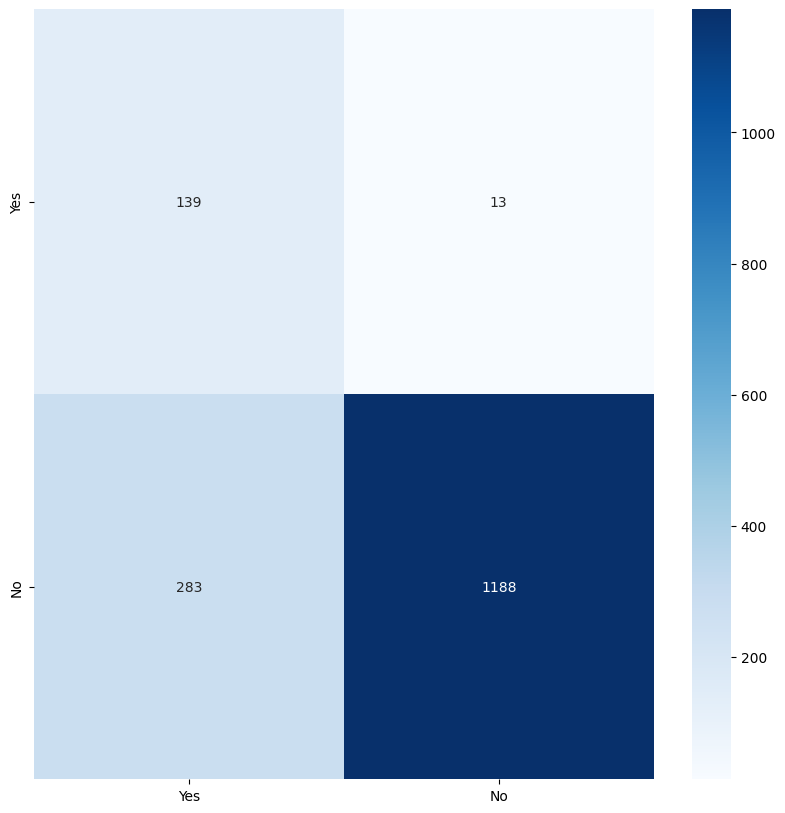

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm1, xticklabels=["Yes","No"], yticklabels=["Yes","No"], annot=True, fmt="d",cmap='Blues')


* Above is the heatmap using Seaborn to visualize the confusion matrix for the validation set. The heatmap displays the true positive (TP), true negative (TN), false positive (FP), and false negative (FN) values.  
* The heatmap provides an easy-to-interpret visualization of the model's performance in classifying positive and negative instances.






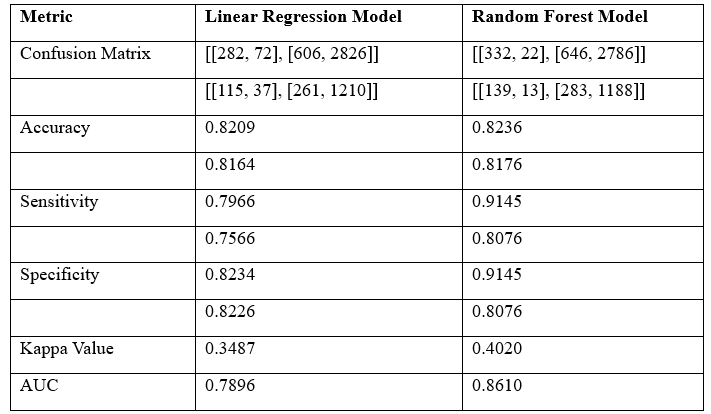

Here based on the comparison, the Random Forest model generally outperforms the Linear Regression model in most metrics, including accuracy, sensitivity, specificity, AUC, and F1-Score. The Random Forest model achieves higher accuracy and better overall performance in predicting both positive and negative instances. However, both models have relatively low F1-Scores, indicating that there might be room for improvement in handling imbalanced classes or other adjustments in model training